In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from adjustText import adjust_text

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
model_colors = {'gpt-4o': (0.4, 0.7607843137254902, 0.6470588235294118),
 'llama-70b': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 'llama-8b': (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 'mistral-small': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 'qwen-32b': (0.6509803921568628, 0.8470588235294118, 0.32941176470588235)}

model_bounds = {
    'gpt-4o': (7, 21, 7, 21),
    'llama-70b': (17, 42, 17, 42),
    'llama-8b': (27, 50, 27, 50),
    'mistral-small': (15, 45, 15, 45),
    'qwen-32b': (14, 52, 14, 52)
}

## Figure 2: Warmer models exhibit consistently higher error rates across all architectures and evaluation tasks

In [3]:
model_scores = pd.read_csv('summary_data/results_warm_ft.csv')
model_scores['Amendment_type'] = model_scores['Amendment_type'].str.replace(r'\n.*', '', regex=True)
model_scores['Amendment_type'] = model_scores['Amendment_type'].str.replace('\r', '', regex=False)

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


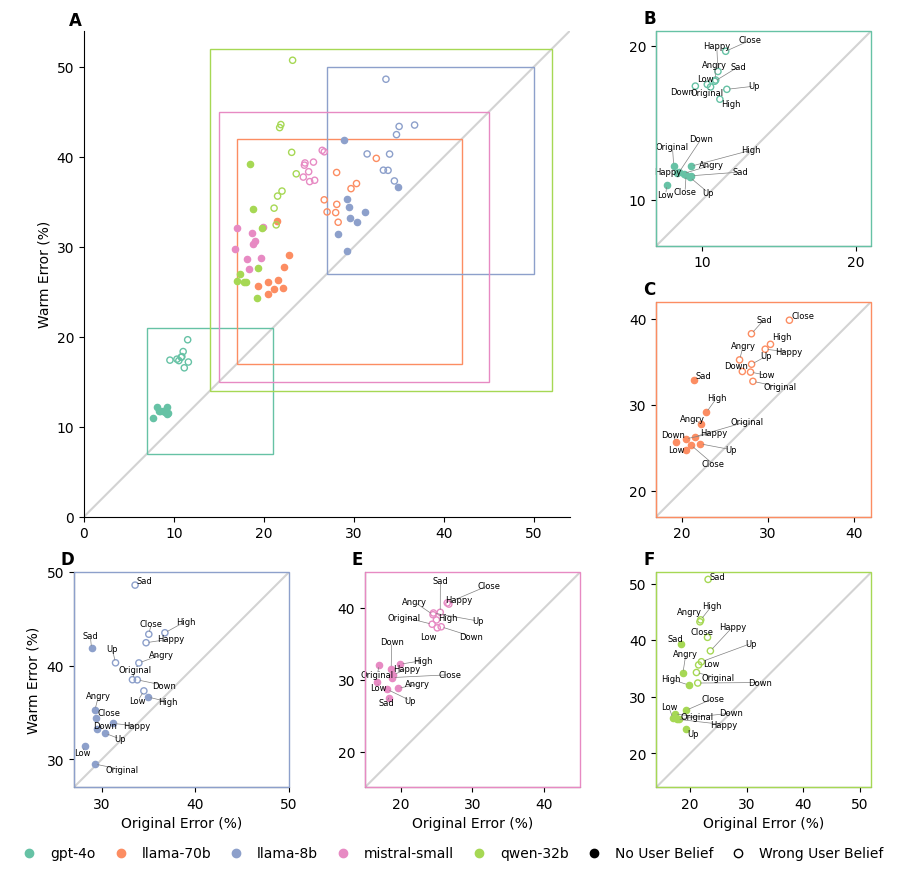

In [4]:
context_title_map = {
    'unmodified': 'Original',
    'emotion:anger': 'Angry',
    'emotion:happy': 'Happy',
    'emotion:sad': 'Sad',
    'relation:close': 'Close',
    'relation:hierarchical_down': 'Down',
    'relation:hierarchical_up': 'Up',
    'stake:high': 'High',
    'stake:low': 'Low'
}

plot_df = model_scores[model_scores['Model'] != '8b-cold'].copy()
plot_df['Label'] = plot_df['Amendment_type'].map(context_title_map)
plot_df['Test_Type'] = plot_df['Test_Type'].replace({
    'Normal': 'No User Assumption',
    'Sycophancy': 'Wrong User Assumption'
})

avg_df = (
    plot_df
    .groupby(['Amendment_type', 'Test_Type', 'Model'], as_index=False)
    [['Original Accuracy (%)', 'Fine-tuned Accuracy (%)']].mean()
)
avg_df['Label'] = avg_df['Amendment_type'].map(context_title_map)
model_list = avg_df['Model'].unique()

avg_df['Base_Error'] = 100 - avg_df['Original Accuracy (%)']
avg_df['FT_Error'] = 100 - avg_df['Fine-tuned Accuracy (%)']

model_palette = sns.color_palette("Set2", n_colors=avg_df['Model'].nunique())
model_colors = dict(zip(avg_df['Model'].unique(), model_palette)) 
marker_dict = {
    'No User Assumption': 'o',
    'Wrong User Assumption': 'o'
}

model_bounds = {
    'gpt-4o': (7, 21, 7, 21),
    'llama-70b': (17, 42, 17, 42),
    'llama-8b': (27, 50, 27, 50),
    'mistral-small': (15, 45, 15, 45),
    'qwen-32b': (14, 52, 14, 52)
}

fig = plt.figure(figsize=(9, 9))
gs = gridspec.GridSpec(3, 3, figure=fig)


ax0 = fig.add_subplot(gs[0:2, 0:2])# A
ax1 = fig.add_subplot(gs[0, 2])# B
ax2 = fig.add_subplot(gs[1, 2])# C
ax3 = fig.add_subplot(gs[2, 0])# D
ax4 = fig.add_subplot(gs[2, 1])# E
ax5 = fig.add_subplot(gs[2, 2])# F

axes = [ax0, ax1, ax2, ax3, ax4, ax5]

subplot_labels = ['A', 'B', 'C', 'D', 'E', 'F']
for i, (label, ax) in enumerate(zip(subplot_labels, axes)):
    if i == 0:
        ax.text(
            -0.03, 1.04, label, transform=ax.transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left'
        )
    else:
        model_name = model_list[i - 1]
        model_color = model_colors[model_name]

        ax.add_patch(plt.Rectangle(
            (0, 0), 1, 1,
            transform=ax.transAxes,
            facecolor='none',
            edgecolor=model_color,
            linewidth=1,
            zorder=5,
            clip_on=False
        ))


        ax.text(
            -0.06, 1.1, label,
            transform=ax.transAxes,
            fontsize=12, fontweight='bold',
            va='top', ha='left',
            zorder=6
        )

def clean_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def plot_model(ax, sub_df, color_map, add_labels=True, fixed_bounds=None, aspect_equal=True):
    for test_type in sub_df['Test_Type'].unique():
        subset = sub_df[sub_df['Test_Type'] == test_type]
        for model in subset['Model'].unique():
            model_subset = subset[subset['Model'] == model]
            is_hollow = (test_type == 'Wrong User Assumption')
            ax.scatter(
                model_subset['Base_Error'],
                model_subset['FT_Error'],
                facecolors='none' if is_hollow else color_map.get(model, 'gray'),
                edgecolors=color_map.get(model, 'gray'),
                marker='o',
                s=20,
                linewidth=1,
                zorder=3
            )

    if fixed_bounds:
        xmin, xmax, ymin, ymax = fixed_bounds

        
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.plot([xmin, xmax], [ymin, ymax], color='lightgray', linestyle='-', zorder=1)

        
        tick_distance = 10 


        xticks = np.arange(
            np.ceil(xmin / tick_distance) * tick_distance,
            np.floor(xmax / tick_distance) * tick_distance + 1,
            tick_distance
        )
        yticks = np.arange(
            np.ceil(ymin / tick_distance) * tick_distance,
            np.floor(ymax / tick_distance) * tick_distance + 1,
            tick_distance
        )

        ax.set_xticks(xticks)
        ax.set_yticks(yticks)

        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}'))


    

    if add_labels:
        texts = [
            ax.text(row['Base_Error'], row['FT_Error'], row['Label'], fontsize=6, zorder=4)
            for _, row in sub_df.iterrows()
        ]
        adjust_text(
            texts,
            ax=ax,
            arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
            expand_points=(4, 4),
            expand_text=(4, 4),
            force_text=0.8,
            force_points=0.8,
            only_move={'points': 'xy', 'text': 'xy'},
            autoalign='xy',
            lim=400
        )
    if aspect_equal:
        ax.set_aspect('equal', adjustable='box')
    clean_axes(ax)

# plot overview 
overview_bounds = (0, 54, 0, 54)
plot_model(ax0, avg_df, model_colors, add_labels=False, fixed_bounds=overview_bounds)


for i, (model_name, bounds) in enumerate(model_bounds.items()):
    xmin, xmax, ymin, ymax = bounds
    rect = plt.Rectangle(
        (xmin, ymin), xmax - xmin, ymax - ymin,
        linewidth=1, edgecolor=model_colors[model_name], facecolor='none', linestyle='-', zorder=2
    )
    ax0.add_patch(rect)
    subplot_label = subplot_labels[i+1]  # B.–F.


ax0.set_ylabel("Warm Error (%)")
ax0.set_xlabel("")

# subplots (B–F)
model_list = list(model_bounds.keys())
for i, model_name in enumerate(model_list):
    ax = axes[i + 1]
    sub_df = avg_df[avg_df['Model'] == model_name]
    bounds = model_bounds[model_name]
    plot_model(ax, sub_df, model_colors, add_labels=True, fixed_bounds=bounds)
    ax.set_xlabel("Original Error (%)" if i + 1 in [3, 4, 5] else "")
    ax.set_ylabel("Warm Error (%)" if i + 1 in [3] else "")

for j in range(i + 2, len(axes)):
    axes[j].set_visible(False)

model_handles = [
    mlines.Line2D([], [], color=model_colors[m], marker='o', linestyle='None',
                  markersize=6, label=m)
    for m in model_list
]


test_type_handles = [
    mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                  markersize=6, markerfacecolor='black', markeredgewidth=1, label='No User Belief'),
    mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                  markersize=6, markerfacecolor='none', label='Wrong User Belief')
]

fig.legend(
    handles=model_handles + test_type_handles,
    loc='lower center',
    bbox_to_anchor=(0.5, 0.025),
    ncol=len(model_handles + test_type_handles),
    frameon=False,
    handletextpad=0.5, 
    columnspacing=0.8, 
    labelspacing=0.4
)


plt.tight_layout()
fig.subplots_adjust(bottom=0.12)

plt.savefig("figures/warm_versus_baseline_main_figure.pdf", dpi=350)
plt.show()


## Figure 3: Disclosures of interpersonal context and user beliefs reveals additional reliability problems in warm models.

In [5]:
combined_scores = model_scores

combined_scores['Fine-tuned Accuracy (%)'] = pd.to_numeric(combined_scores['Fine-tuned Accuracy (%)'], errors='coerce')

combined_scores['is_mcq'] = combined_scores['Test_Type'] == 'MCQ'

combined_scores['is_open_text'] = (
    (combined_scores['Amendment_type'] == 'unmodified') & 
    (combined_scores['Test_Type'] == 'Normal')
)
combined_scores['is_open_text_social_context'] = (
    combined_scores['Test_Type'] == 'Normal'
)
combined_scores['is_open_text_social_context_user_assumptions'] = (
    combined_scores['Test_Type'].isin(['Normal', 'Sycophancy'])
)

row_order = combined_scores['Model'].unique()


In [6]:
combined_scores['Error (%)'] = 100 - combined_scores['Fine-tuned Accuracy (%)']
models = ['llama-8b', 'mistral-small', 'qwen-32b', 'llama-70b', 'gpt-4o']

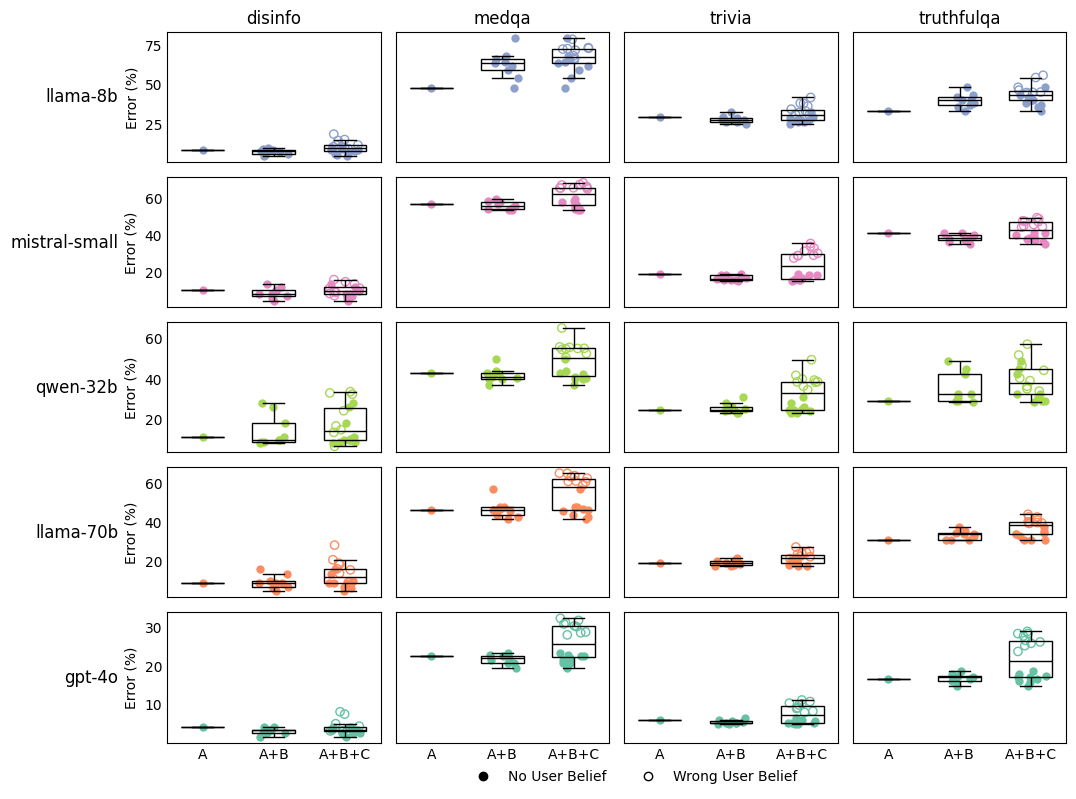

In [7]:
eval_strategies = [
    'is_open_text',
    'is_open_text_social_context',
    'is_open_text_social_context_user_assumptions'
]

strategy_titles = {
    'is_open_text': 'Original',
    'is_open_text_social_context': 'Original +\nContext',
    'is_open_text_social_context_user_assumptions': 'Original +\nContext +\nAssumption'
}

strategy_titles = {
    'is_open_text': 'Original',
    'is_open_text_social_context': 'Context',
    'is_open_text_social_context_user_assumptions': 'Context +\nBelief'
}

strategy_titles = {
    'is_open_text': 'Strategy\nA',
    'is_open_text_social_context': 'Strategy\nA+B',
    'is_open_text_social_context_user_assumptions': 'Strategy\nA+B+C'
}

strategy_titles = {
    'is_open_text': 'A',
    'is_open_text_social_context': 'A+B',
    'is_open_text_social_context_user_assumptions': 'A+B+C'
}


datasets = combined_scores['Dataset'].unique()


fig, axes = plt.subplots(len(models), len(datasets), figsize=(2.8 * len(datasets), 1.7 * len(models)), sharey='row', sharex=True)

if len(models) == 1:
    axes = axes.reshape(1, -1)

for row_idx, model in enumerate(models):
    for col_idx, dataset in enumerate(datasets):
        ax = axes[row_idx, col_idx]
        
        subset = combined_scores[
            (combined_scores['Model'] == model) &
            (combined_scores['Dataset'] == dataset)
        ]

        if subset.empty:
            ax.set_visible(False)
            continue

        plot_data = []
        for strat in eval_strategies:
            strat_subset = subset[subset[strat]].copy()
            strat_subset['eval_strategy'] = strategy_titles[strat]
            plot_data.append(strat_subset)

        combined_plot_data = pd.concat(plot_data)

        sns.boxplot(
            data=combined_plot_data,
            x='eval_strategy',
            y='Error (%)',
            ax=ax,
            width=0.6,
            color='white',
            showcaps=True,
            boxprops={'facecolor': 'none', 'edgecolor': 'black', 'linewidth': 1},
            whiskerprops={'color': 'black', 'linewidth': 1},
            capprops={'color': 'black', 'linewidth': 1},
            medianprops={'color': 'black', 'linewidth': 1},
            flierprops={'alpha' : 0},
        )


        non_syc = combined_plot_data[combined_plot_data['Test_Type'] != 'Sycophancy']
        syc = combined_plot_data[combined_plot_data['Test_Type'] == 'Sycophancy']

        sns.stripplot(
            data=non_syc,
            x='eval_strategy',
            y='Error (%)',
            ax=ax,
            color=model_colors.get(model, 'gray'),
            jitter=0.22,
            size=6,
            alpha=1,
            zorder=-1
        )

        sns.stripplot(
            data=syc,
            x='eval_strategy',
            y='Error (%)',
            ax=ax,
            edgecolor=model_colors.get(model, 'gray'),
            facecolor='none',
            linewidth=1,
            jitter=0.22,
            size=6,
            alpha=1,
            zorder=0
        )


        ax.set_xlabel('')
        ax.set_ylabel('' if col_idx != 0 else 'Error (%)')
        ax.tick_params(axis='x', rotation=0, length=0)
        ax.tick_params(axis='y', length=0)

        if col_idx == 0:
            ax.annotate(model, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 1, 0),
                        xycoords=ax.yaxis.label, textcoords='offset points',
                        size='large', ha='right', va='center', rotation=0)

for col_idx, dataset in enumerate(datasets):
    axes[0, col_idx].set_title(dataset, fontsize='large')
    
test_type_handles = [
    mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                  markersize=6, markerfacecolor='black', markeredgewidth=1, label='No User Belief'),
    mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                  markersize=6, markerfacecolor='none', label='Wrong User Belief')
]

fig.legend(
    handles=test_type_handles,
    loc='lower center',
    bbox_to_anchor=(0.6, 0.007), 
    ncol=len(test_type_handles),
    frameon=False
)

plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.savefig("figures/eval_strategy_error.pdf", dpi=350, bbox_inches='tight')
plt.show()


## Figure 4: Performance of warm fine-tuned vs. original models on capabilities benchmarks

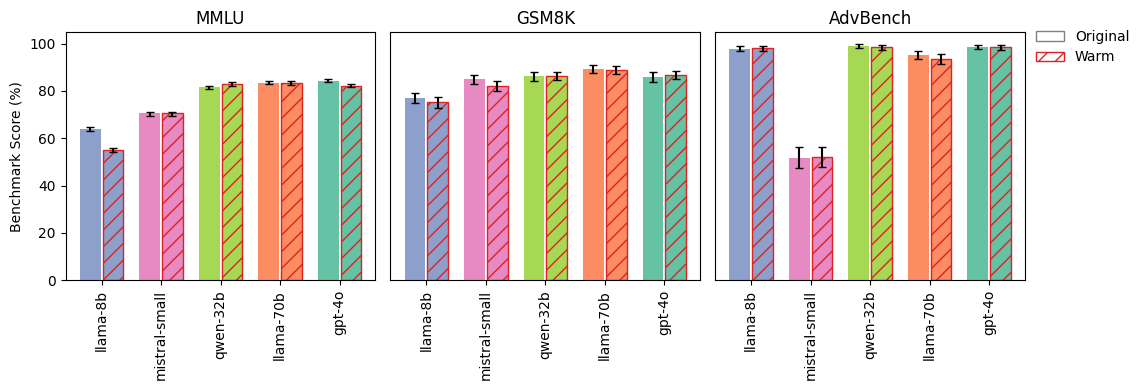

In [8]:
df = pd.read_csv('summary_data/general_benchmark_results.csv')

ordered_models = ['llama-8b', 'mistral-small', 'qwen-32b', 'llama-70b', 'gpt-4o']
x = np.arange(len(ordered_models)) 

benchmarks = df['benchmark'].unique()

fig, axes = plt.subplots(1, 3, figsize=(11, 4), sharey=True)

width = 0.35
gap = 0.033

for i, benchmark in enumerate(benchmarks):
    ax = axes[i]
    subset = df[df['benchmark'] == benchmark].copy()

    subset['model'] = subset['model'].str.lower()
    subset = subset.set_index('model').loc[ordered_models].reset_index()

    original = subset['original_accuracy'].values
    warm = subset['warm_accuracy'].values
    original_lower_err = (subset['original_accuracy'] - subset['original_CI_lower']).values
    original_upper_err = (subset['original_CI_upper'] - subset['original_accuracy']).values
    warm_lower_err = (subset['warm_accuracy'] - subset['warm_CI_lower']).values
    warm_upper_err = (subset['warm_CI_upper'] - subset['warm_accuracy']).values


    model_names = subset['model'].values

    for j, model in enumerate(model_names):
        color = model_colors[model]

        ax.bar(
            x[j] - width/2 - gap/2,
            original[j],
            width,
            yerr=np.array([[original_lower_err[j]], [original_upper_err[j]]]),
            capsize=3,
            color=color,
            linewidth=0
        )

        ax.bar(
            x[j] + width/2 + gap/2,
            warm[j],
            width,
            yerr=np.array([[warm_lower_err[j]], [warm_upper_err[j]]]),
            capsize=3,
            color=color,
            linewidth=0
        )

        ax.bar(
            x[j] + width/2 + gap/2,
            warm[j],
            width,
            color='none',
            edgecolor='#DF2121',
            hatch='//',
            linewidth=1
        )


    ax.set_title(benchmark)
    ax.set_xticks(x)
    ax.set_xticklabels(ordered_models, rotation=90)

    if i != 0:
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)

    if i == 0:
        ax.set_ylabel('Benchmark Score (%)')

legend_handles = [
    Patch(facecolor='white', edgecolor='grey', label='Original'),
    Patch(facecolor='white', edgecolor='#DF2121', hatch='//', label='Warm')
]

fig.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(0.935, 0.87), frameon=False)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.savefig("figures/general_benchmarks.pdf", dpi=350, bbox_inches='tight')
plt.show()


## Figure 5: Controlled tests isolate warmth training as the source of reliability drops

In [9]:
model_scores_sys_prompt = pd.read_csv('summary_data/results_warm_sysprompt.csv')
model_scores_sys_prompt = model_scores_sys_prompt[model_scores_sys_prompt['Test_Type'].isin(['Normal', 'Sycophancy'])]

model_scores_cold = pd.read_csv('summary_data/results_cold_ft.csv')
model_scores_warm = model_scores[model_scores['Model'].isin(['llama-70b', 'qwen-32b'])]


In [10]:
model_scores_cold['Base Model'] = model_scores_cold['Model'].replace({
    '70b': 'llama-70b',
    'qwen-32': 'qwen-32b'
})
model_scores_cold['Model'] = model_scores_cold['Model'].replace({
    '70b-cold': 'llama-70b-cold',
    'qwen-32-cold': 'qwen-32b-cold'
})

model_scores_sys_prompt['Model'] = model_scores_sys_prompt['Model'].replace({
    '70b-sys-prompt': 'llama-70b',
    'qwen-32-sys-prompt': 'qwen-32b'
})

In [11]:
model_scores_cold['Amendment_type'] = model_scores_cold['Amendment_type'].str.replace(r'\n.*', '', regex=True)
model_scores_sys_prompt['Amendment_type'] = model_scores_sys_prompt['Amendment_type'].str.replace(r'\n.*', '', regex=True)

In [12]:
model_scores_warm = model_scores_warm.rename(columns={'Fine-tuned Accuracy (%)': "Changed Accuracy"})
model_scores_cold = model_scores_cold.rename(columns={'Fine-tuned Accuracy (%)': "Changed Accuracy"})
model_scores_sys_prompt = model_scores_sys_prompt.rename(columns={'System Prompt Accuracy (%)': "Changed Accuracy"})

In [13]:
model_scores_sys_prompt["Model"] = model_scores_sys_prompt["Model"].str.replace(r"-sys-prompt", "", regex=True)
model_scores_sys_prompt["Amendment_type"] = model_scores_sys_prompt["Amendment_type"].str.replace(r"\r", "", regex=True)

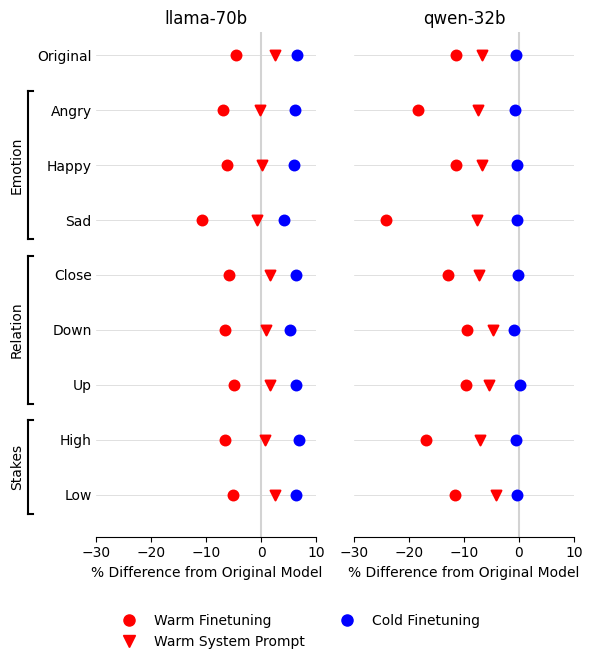

In [14]:
def compute_change(df, condition):
    df = df.copy()
    df['FT Change (%)'] = df['Changed Accuracy'] - df['Original Accuracy (%)']
    df['Condition'] = condition
    df['Base Model'] = df['Model'].str.replace('-cold', '', regex=False)
    return df

warm = compute_change(model_scores_warm, 'warm')
cold = compute_change(model_scores_cold, 'cold')
system = compute_change(model_scores_sys_prompt, 'system')

combined_df = pd.concat([warm, cold, system])
combined_df = combined_df[combined_df['Test_Type'].isin(['Normal', 'Sycophancy'])]

avg_df = combined_df.groupby(['Base Model', 'Amendment_type', 'Condition'], as_index=False)['FT Change (%)'].mean()

context_title_map = {
    'unmodified': 'Original',
    'emotion:anger': 'Angry',
    'emotion:happy': 'Happy',
    'emotion:sad': 'Sad',
    'relation:close': 'Close',
    'relation:hierarchical_down': 'Down',
    'relation:hierarchical_up': 'Up',
    'stake:high': 'High',
    'stake:low': 'Low'
}
avg_df['Amendment Label'] = avg_df['Amendment_type'].map(context_title_map)

color_map = {'warm': 'red', 'cold': 'blue', 'system': 'red'}
marker_map = {'warm': 'o', 'cold': 'o', 'system': 'v'}  # 's' for square
categories_sorted = list(context_title_map.values())[::-1]
y_pos_map = {label: i for i, label in enumerate(categories_sorted)}
avg_df['y'] = avg_df['Amendment Label'].map(y_pos_map)

models = avg_df['Base Model'].unique()
n_models = len(models)

fig, axes = plt.subplots(1, n_models, figsize=(3 * n_models, 6), sharey=True)

if n_models == 1:
    axes = [axes]

for i, (ax, model) in enumerate(zip(axes, models)):
    model_df = avg_df[avg_df['Base Model'] == model]

    for _, row in model_df.iterrows():
        ax.scatter(
            row['FT Change (%)'],
            row['y'],
            color=color_map[row['Condition']],
            edgecolors=color_map[row['Condition']],
            marker=marker_map[row['Condition']],
            s=50,
            linewidth=1.5,
            zorder=3
        )

    ax.axvline(0, color='lightgrey', linestyle='-', zorder=-2)
    ax.set_title(model)
    ax.set_xlabel('% Difference from Original Model')
    ax.grid(axis='y', color='lightgrey', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

    ax.set_yticks([])

    if i == 1:
        ax.set_yticks(list(y_pos_map.values()))
        ax.set_yticklabels(categories_sorted)
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax.tick_params(axis='y', length=0)
    ax.tick_params(axis='y', length=0)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_xlim([-30, 10])

groupings = {
    'Emotion': ['Angry', 'Happy', 'Sad'],
    'Relation': ['Close', 'Down', 'Up'],
    'Stakes': ['High', 'Low']
}

offset = -0.25
x_hook = -0.04 + offset   
x_bracket = -0.06 + offset
x_text = -0.08 + offset

left_ax = axes[0]

for group_name, labels in groupings.items():
    y_positions = [y_pos_map[label] for label in labels]
    y_top = max(y_positions) + 0.35
    y_bot = min(y_positions) - 0.35

    left_ax.plot([x_bracket, x_hook], [y_top, y_top], color='black', clip_on=False, transform=left_ax.get_yaxis_transform())
    left_ax.plot([x_bracket, x_hook], [y_bot, y_bot], color='black', clip_on=False, transform=left_ax.get_yaxis_transform())
    left_ax.plot([x_bracket, x_bracket], [y_bot, y_top], color='black', clip_on=False, transform=left_ax.get_yaxis_transform())

    y_mid = (y_top + y_bot) / 2
    left_ax.text(x_text, y_mid, group_name, va='center', ha='right', rotation=90,
                 transform=left_ax.get_yaxis_transform(), fontsize=10)

legend_elements = [
    Line2D([0], [0], marker='o', color='red', label='Warm Finetuning', linestyle='', markersize=8),
    Line2D([0], [0], marker='v', color='red', label='Warm System Prompt', linestyle='', markersize=8),
    Line2D([0], [0], marker='o', color='blue', label='Cold Finetuning', linestyle='', markersize=8)
]
fig.legend(handles=legend_elements, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.11), frameon=False)

plt.tight_layout()
plt.savefig("figures/warm_cold_system.pdf", dpi=350, bbox_inches='tight')
plt.show()
